In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# Examine/Combine files

## Wind

In [5]:
wind_east = xr.open_mfdataset('shared/data/era5/eastward_wind_at_10_metres/*.nc')
wind_north = xr.open_mfdataset('shared/data/era5/northward_wind_at_10_metres/*.nc')

In [6]:
wind_east = wind_east.rename({'time0':'time', 'eastward_wind_at_10_metres': 'u_wind'})
wind_north = wind_north.rename({'time0':'time', 'northward_wind_at_10_metres': 'v_wind'})

In [10]:
wind_east

<xarray.Dataset>
Dimensions:  (lon: 241, lat: 177, time: 184104)
Coordinates:
  * lon      (lon) float32 42.0 42.25 42.5 42.75 ... 101.2 101.5 101.8 102.0
  * lat      (lat) float32 32.0 31.75 31.5 31.25 ... -11.25 -11.5 -11.75 -12.0
  * time     (time) datetime64[ns] 2000-01-01 ... 2020-12-31T23:00:00
Data variables:
    u_wind   (time, lat, lon) float32 dask.array<chunksize=(744, 177, 241), meta=np.ndarray>
Attributes:
    source:       Reanalysis
    institution:  ECMWF
    tilte:        ERA5 forecasts

In [11]:
wind_east.to_netcdf('shared/data/u_comp_wind.nc')
wind_north.to_netcdf('shared/data/v_comp_wind.nc')

KeyboardInterrupt: 

In [ ]:
wind_east.load().to_netcdf('shared/data/uwind.nc')

In [8]:
daily_east = wind_east.coarsen(time=24).mean(keep_attrs=True).compute()

In [21]:
daily_north = wind_north.coarsen(time=24).mean(keep_attrs=True).compute()

In [22]:
wind_reanalysis = xr.combine_by_coords([daily_east, daily_north])
wind_reanalysis = wind_reanalysis.assign(speed = np.sqrt(wind_reanalysis.u_wind**2 + wind_reanalysis.v_wind**2))
wind_reanalysis = wind_reanalysis.assign(direction = np.rad2deg(np.arctan2(wind_reanalysis.v_wind, wind_reanalysis.u_wind)))

In [23]:
wind_reanalysis.time.shape

(7671,)

In [25]:
wind_reanalysis

<xarray.Dataset>
Dimensions:    (time: 7671, lat: 177, lon: 241)
Coordinates:
  * lon        (lon) float32 42.0 42.25 42.5 42.75 ... 101.2 101.5 101.8 102.0
  * lat        (lat) float32 32.0 31.75 31.5 31.25 ... -11.25 -11.5 -11.75 -12.0
  * time       (time) datetime64[ns] 2000-01-01T11:30:00 ... 2020-12-31T11:30:00
Data variables:
    u_wind     (time, lat, lon) float32 0.9761 0.8111 0.9959 ... -1.992 -1.734
    v_wind     (time, lat, lon) float32 -0.8542 -0.8382 -1.024 ... 3.138 3.18
    speed      (time, lat, lon) float32 1.297 1.166 1.428 ... 3.849 3.717 3.622
    direction  (time, lat, lon) float32 -41.19 -45.94 -45.78 ... 122.4 118.6
Attributes:
    source:       Reanalysis
    institution:  ECMWF
    tilte:        ERA5 forecasts

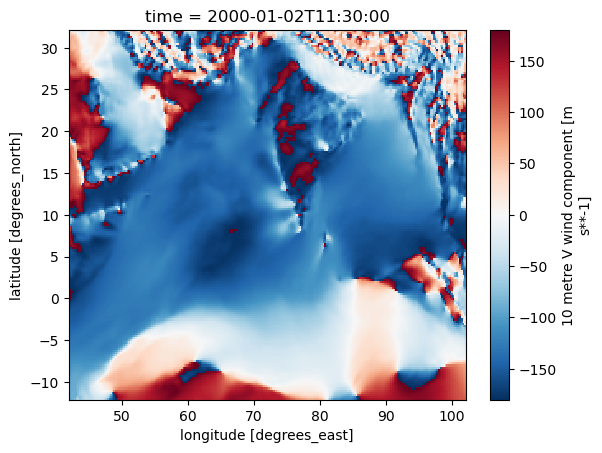

In [24]:
wind_reanalysis['direction'].isel(time=1).plot.imshow()

In [7]:
array_for_interpolation = wind_east.isel(time=0)

In [8]:
array_for_interpolation.to_netcdf('data/grid.nc')

In [26]:
wind_reanalysis.chunk({'time': wind_reanalysis.time.shape[0]}).to_zarr('shared/data/wind_all.zarr')

ContainsGroupError: path '' contains a group

In [27]:
wind_reanalysis.to_zarr('shared/data/wind_all.zarr')

In [ ]:
wind_reanalysis[['u_wind', 'v_wind']].load().to_netcdf('wind_comp.nc')

## SLA

In [44]:
sla = xr.open_mfdataset('cop_sla/*.nc')

In [3]:
sla

<xarray.Dataset>
Dimensions:    (time: 7671, latitude: 176, longitude: 240)
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2020-12-31
  * latitude   (latitude) float32 -11.88 -11.62 -11.38 ... 31.38 31.62 31.88
  * longitude  (longitude) float32 42.12 42.38 42.62 42.88 ... 101.4 101.6 101.9
Data variables:
    sla        (time, latitude, longitude) float64 dask.array<chunksize=(366, 176, 240), meta=np.ndarray>
    adt        (time, latitude, longitude) float64 dask.array<chunksize=(366, 176, 240), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         http://climate.copernicus.eu/c3s-user-se...
    creator_email:                   http://climate.copernicus.eu/c3s-user-se...
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               2000-01-01T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             1999-12-31T12:00:00Z
    title:                           DT merged two satellites Global Ocean Gr...

In [8]:
# Interpolating
interp = sla.rename({"latitude": "lat", "longitude": "lon"}).interp_like(array_for_interpolation)

In [9]:
interp

<xarray.Dataset>
Dimensions:  (time: 7671, lat: 177, lon: 241)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2020-12-31
  * lon      (lon) float32 42.0 42.25 42.5 42.75 ... 101.2 101.5 101.8 102.0
  * lat      (lat) float32 32.0 31.75 31.5 31.25 ... -11.25 -11.5 -11.75 -12.0
Data variables:
    sla      (time, lat, lon) float64 dask.array<chunksize=(366, 177, 241), meta=np.ndarray>
    adt      (time, lat, lon) float64 dask.array<chunksize=(366, 177, 241), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         http://climate.copernicus.eu/c3s-user-se...
    creator_email:                   http://climate.copernicus.eu/c3s-user-se...
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               2000-01-01T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             1999-12-31T12:00:00Z
    title:                           DT merged two satellites Global Ocean Gr...

In [10]:
interp.to_netcdf('shared/data/sla.nc')

## Rest of ERA5

In [30]:
xr.open_dataset('shared/data/era5/air_temperature_at_2_metres/200001.nc')

<xarray.Dataset>
Dimensions:                      (lon: 241, lat: 177, time0: 744)
Coordinates:
  * lon                          (lon) float32 42.0 42.25 42.5 ... 101.8 102.0
  * lat                          (lat) float32 32.0 31.75 31.5 ... -11.75 -12.0
  * time0                        (time0) datetime64[ns] 2000-01-01 ... 2000-0...
Data variables:
    air_temperature_at_2_metres  (time0, lat, lon) float32 ...
Attributes:
    source:       Reanalysis
    institution:  ECMWF
    tilte:        ERA5 forecasts

In [33]:
vars = {'air_temperature_at_2_metres': 'air_temp_2m', 'sea_surface_temperature': 'sst'}
for var, new_name in vars.items():
    ds = xr.open_mfdataset(f'shared/data/era5/{var}/*.nc')
    ds = ds.rename({'time0':'time', var: new_name})
    ds = ds.coarsen(time=24).mean(keep_attrs=True).compute()
    ds.to_netcdf(f'shared/data/finalized/{new_name}.nc')
    print('done1...')

done1...
done1...


In [21]:
xr.open_dataset('shared/data/finalized/sst.nc')

<xarray.Dataset>
Dimensions:  (time: 7671, lat: 177, lon: 241)
Coordinates:
  * lon      (lon) float32 42.0 42.25 42.5 42.75 ... 101.2 101.5 101.8 102.0
  * lat      (lat) float32 32.0 31.75 31.5 31.25 ... -11.25 -11.5 -11.75 -12.0
  * time     (time) datetime64[ns] 2000-01-01T11:30:00 ... 2020-12-31T11:30:00
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    source:       Reanalysis
    institution:  ECMWF
    tilte:        ERA5 forecasts

## Chlorophyll-a

In [34]:
chloro = xr.open_mfdataset('chlorophyll/motu-chloro/*.nc')

In [38]:
chloro = chloro.sel(time=slice('2000-01-01', '2020-12-31'))

In [39]:
chloro

<xarray.Dataset>
Dimensions:          (time: 7669, lat: 1057, lon: 1441)
Coordinates:
  * time             (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2020-12-31
  * lat              (lat) float32 32.02 31.98 31.94 ... -11.9 -11.94 -11.98
  * lon              (lon) float32 41.98 42.02 42.06 42.1 ... 101.9 101.9 102.0
Data variables:
    CHL_uncertainty  (time, lat, lon) float32 dask.array<chunksize=(31, 1057, 1441), meta=np.ndarray>
    CHL              (time, lat, lon) float32 dask.array<chunksize=(31, 1057, 1441), meta=np.ndarray>
Attributes: (12/92)
    lon_step:                        0.041666668
    keywords:                        EARTH SCIENCE > OCEANS > OCEAN CHEMISTRY...
    cmems_product_id:                OCEANCOLOUR_GLO_BGC_L4_MY_009_104
    lat_step:                        0.041666668
    grid_mapping:                    Equirectangular
    title:                           cmems_obs-oc_glo_bgc-plankton_my_l4-gapf...
    ...                              ...
    westernmost_longitude:           -180.0
    geospatial_vertical_positive:    up
    date_created:                    2023-06-30T00:51:14Z
    nb_valid_bins:                   18756678
    pct_valid_bins:                  50.25258809156379
    History:                         Translated to CF-1.0 Conventions by Netc...

In [46]:
true_freq = np.array([s.to_datetime64() for s in pd.date_range('2000/1/1', '2020/12/31', freq='1D')])

In [47]:
np.setdiff1d(true_freq, chloro.time.values)

array(['2000-11-17T00:00:00.000000000', '2001-11-18T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [45]:
np.setdiff1d(sla.time.values, true_freq).

array(['2000-01-01T00:00:00.000000000', '2000-01-02T00:00:00.000000000',
       '2000-01-03T00:00:00.000000000', ...,
       '2014-12-29T00:00:00.000000000', '2014-12-30T00:00:00.000000000',
       '2014-12-31T00:00:00.000000000'], dtype='datetime64[ns]')

In [48]:
chloro_resampled = chloro.resample(time='D').asfreq()

TypeError: __init__() got an unexpected keyword argument 'base'

In [49]:
chloro_resampled = chloro.reindex({'time': true_freq})

In [62]:
chloro_interp = chloro_resampled.interp_like(array_for_interpolation)

In [63]:
chloro_interp

<xarray.Dataset>
Dimensions:          (time: 7671, lat: 177, lon: 241)
Coordinates:
  * time             (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2020-12-31
  * lon              (lon) float32 42.0 42.25 42.5 42.75 ... 101.5 101.8 102.0
  * lat              (lat) float32 32.0 31.75 31.5 31.25 ... -11.5 -11.75 -12.0
Data variables:
    CHL_uncertainty  (time, lat, lon) float32 dask.array<chunksize=(31, 177, 241), meta=np.ndarray>
    CHL              (time, lat, lon) float32 dask.array<chunksize=(31, 177, 241), meta=np.ndarray>
Attributes: (12/92)
    lon_step:                        0.041666668
    keywords:                        EARTH SCIENCE > OCEANS > OCEAN CHEMISTRY...
    cmems_product_id:                OCEANCOLOUR_GLO_BGC_L4_MY_009_104
    lat_step:                        0.041666668
    grid_mapping:                    Equirectangular
    title:                           cmems_obs-oc_glo_bgc-plankton_my_l4-gapf...
    ...                              ...
    westernmost_longitude:           -180.0
    geospatial_vertical_positive:    up
    date_created:                    2023-06-30T00:51:14Z
    nb_valid_bins:                   18756678
    pct_valid_bins:                  50.25258809156379
    History:                         Translated to CF-1.0 Conventions by Netc...

In [64]:
chloro_resampled

<xarray.Dataset>
Dimensions:          (time: 7671, lat: 1057, lon: 1441)
Coordinates:
  * time             (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2020-12-31
  * lat              (lat) float32 32.02 31.98 31.94 ... -11.9 -11.94 -11.98
  * lon              (lon) float32 41.98 42.02 42.06 42.1 ... 101.9 101.9 102.0
Data variables:
    CHL_uncertainty  (time, lat, lon) float32 dask.array<chunksize=(31, 1057, 1441), meta=np.ndarray>
    CHL              (time, lat, lon) float32 dask.array<chunksize=(31, 1057, 1441), meta=np.ndarray>
Attributes: (12/92)
    lon_step:                        0.041666668
    keywords:                        EARTH SCIENCE > OCEANS > OCEAN CHEMISTRY...
    cmems_product_id:                OCEANCOLOUR_GLO_BGC_L4_MY_009_104
    lat_step:                        0.041666668
    grid_mapping:                    Equirectangular
    title:                           cmems_obs-oc_glo_bgc-plankton_my_l4-gapf...
    ...                              ...
    westernmost_longitude:           -180.0
    geospatial_vertical_positive:    up
    date_created:                    2023-06-30T00:51:14Z
    nb_valid_bins:                   18756678
    pct_valid_bins:                  50.25258809156379
    History:                         Translated to CF-1.0 Conventions by Netc...

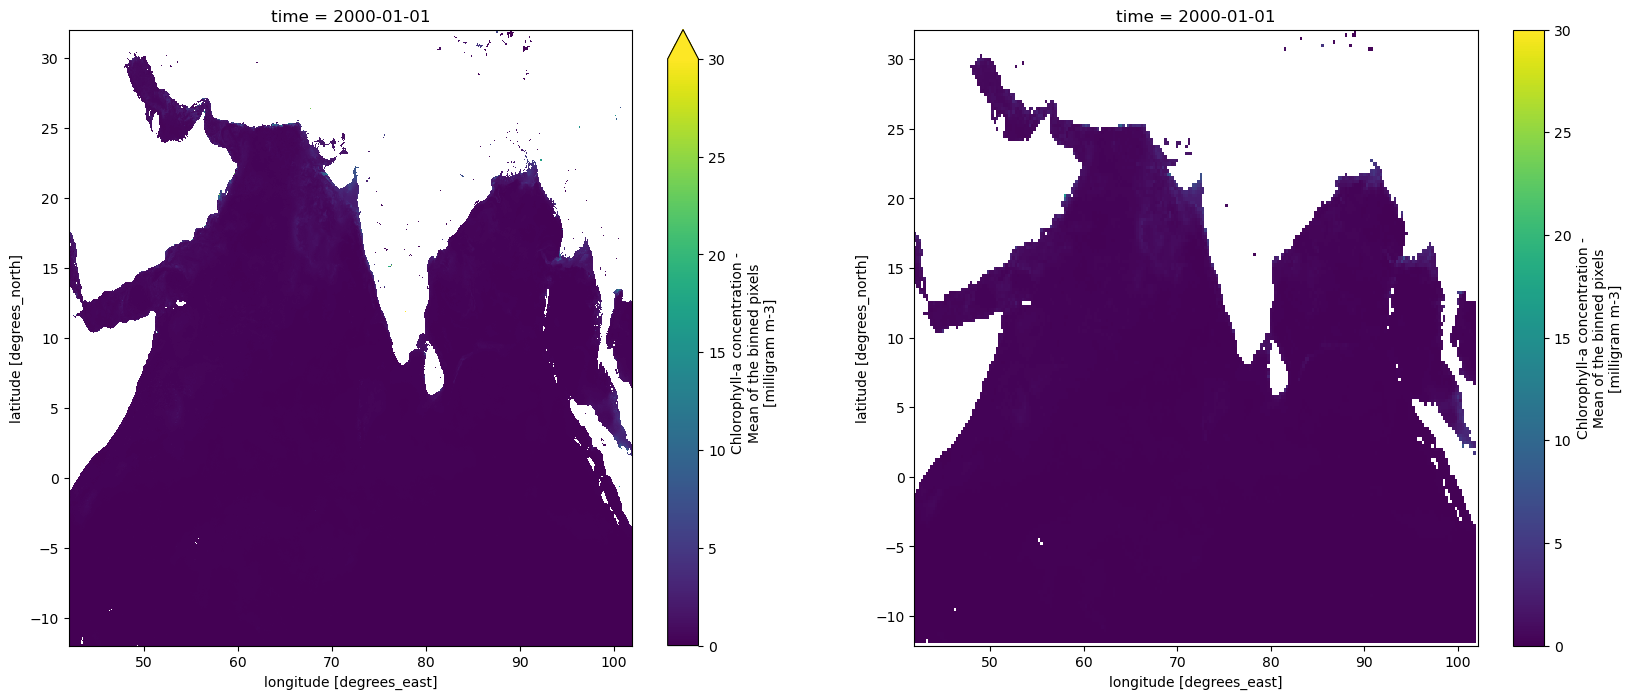

In [68]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
chloro_resampled['CHL'].isel(time=0).plot.imshow(ax=ax1, vmax=30, vmin=0)
chloro_interp['CHL'].isel(time=0).plot.imshow(ax=ax2, vmax=30, vmin=0) # interpolation on smaller resolution

In [70]:
chloro_interp.to_netcdf('shared/data/finalized/chlorophyll-a.nc')

## Topography

In [14]:
topo = xr.open_dataarray('data/topography.nc')

In [15]:
grid = xr.open_dataarray('data/grid.nc')

In [17]:
topo = topo.rename({'latitude': 'lat', 'longitude': 'lon'})

ValueError: cannot rename 'latitude' because it is not a variable or dimension in this dataset

In [18]:
topo_interp = topo.interp_like(grid)

In [20]:
topo_interp.to_netcdf('shared/data/finalized/topography.nc')

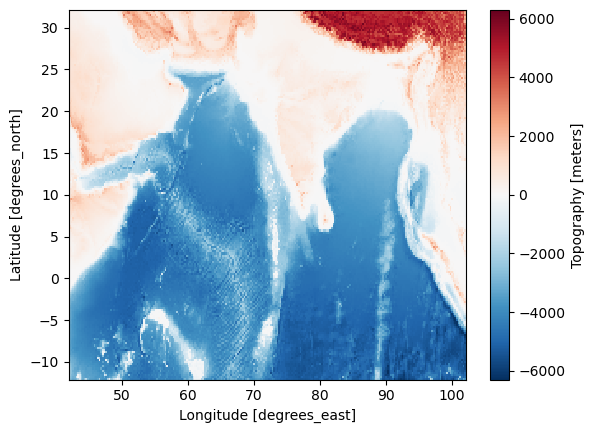

In [19]:
topo_interp.plot.imshow()

In [12]:
grid

<xarray.DataArray 'u_wind' (lat: 177, lon: 241)>
array([[ 2.966461,  2.765289,  2.828766, ...,  1.945953,  1.754547, -0.042328],
       [ 2.830719,  2.629547,  2.755524, ...,  1.507477,  1.840485,  0.033844],
       [ 2.822906,  2.60025 ,  2.722321, ...,  0.739899,  2.316071,  0.575836],
       ...,
       [-0.685883, -0.738617, -0.749359, ..., -4.564789, -4.555023, -4.651703],
       [-0.844086, -0.830414, -0.902679, ..., -4.936859, -4.883148, -4.842133],
       [-0.918304, -0.874359, -0.92514 , ..., -5.235687, -5.159515, -5.071625]],
      dtype=float32)
Coordinates:
  * lon      (lon) float32 42.0 42.25 42.5 42.75 ... 101.2 101.5 101.8 102.0
  * lat      (lat) float32 32.0 31.75 31.5 31.25 ... -11.25 -11.5 -11.75 -12.0
    time     datetime64[ns] 2000-01-01
Attributes:
    standard_name:   eastward_wind
    units:           m s**-1
    long_name:       10 metre U wind component
    nameECMWF:       10 metre U wind component
    shortNameECMWF:  10u
    nameCDM:         10_metre_U_wind_component_surface
    product_type:    analysis

## Geostrophic & surface currents

In [2]:
ocean_currents = xr.open_mfdataset('earthdata/OSCAR_L4_OC_FINAL_V2.0/*.nc')

In [3]:
ocean_currents = ocean_currents.transpose('time', 'latitude', 'longitude')

In [4]:
ocean_currents['time'] = ocean_currents.indexes['time'].to_datetimeindex()

/tmp/ipykernel_1081/890172513.py:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  ocean_currents['time'] = ocean_currents.indexes['time'].to_datetimeindex()


In [5]:
ocean_currents_modified =ocean_currents.rename({'longitude': 'lon', 'latitude': 'lat'})

In [6]:
unique_idxs = np.unique(ocean_currents.time, return_index=True)[1]

In [7]:
unique_idxs.shape

(7671,)

In [7]:
ocean_currents = ocean_currents.isel(time=unique_idxs)
ocean_currents_modified = ocean_currents_modified.isel(time=unique_idxs)

In [8]:
ocean_currents.to_netcdf('shared/data/finalized/currents.nc')
ocean_currents_modified.to_netcdf('shared/data/finalized/currents_modified.nc')

Text(0.5, 1.0, 'non geostrophic current')

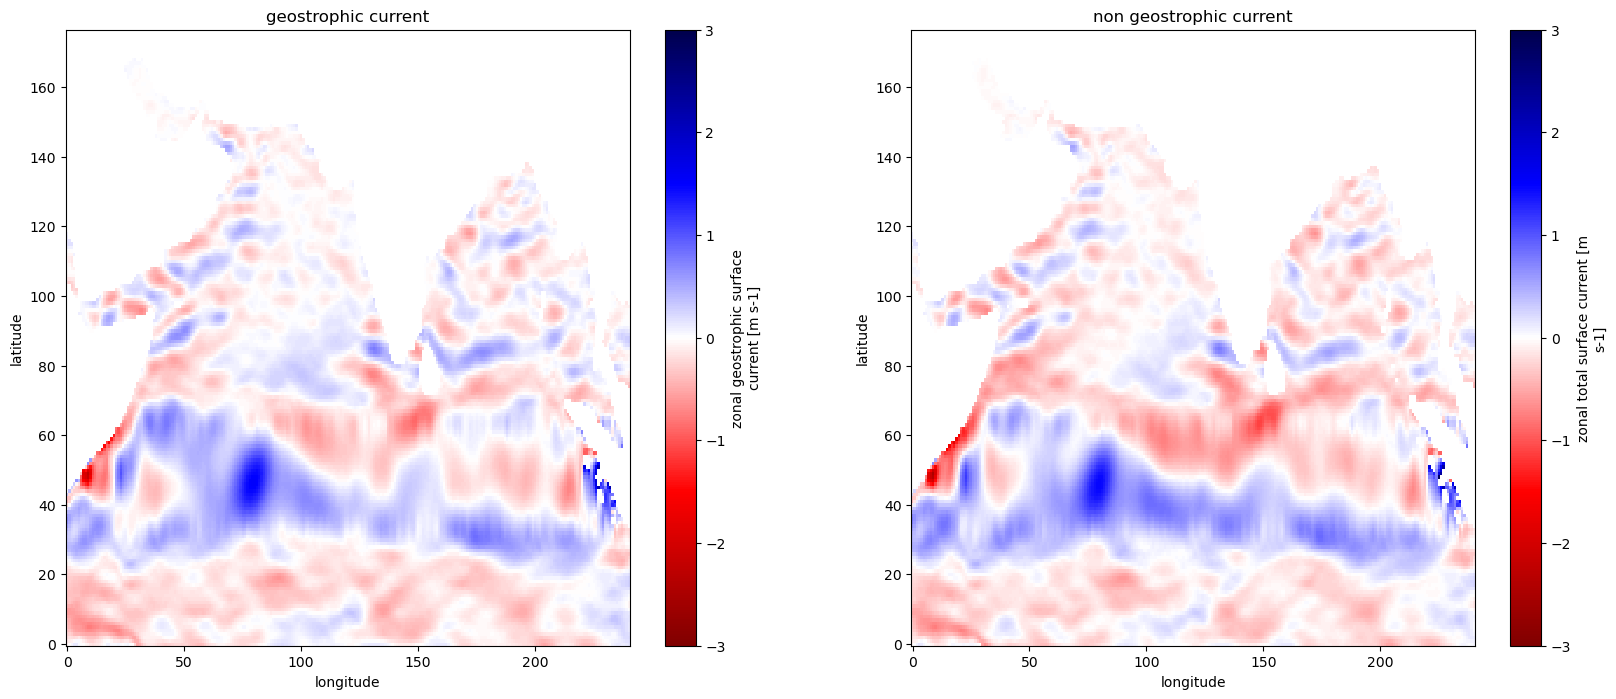

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
ocean_currents['ug'].isel(time=0).plot.imshow(ax=axs[0], vmin=-3, cmap='seismic_r', vmax=3, center=0)
ocean_currents['u'].isel(time=0).plot.imshow(ax=axs[1], vmin=-3, cmap='seismic_r',vmax=3, center=0)
axs[0].set_title('geostrophic current')
axs[1].set_title('non geostrophic current')

## Transforming coordinates

In [4]:
hell = xr.open_dataset('shared/data/finalized/currents.nc')

In [29]:
hell

<xarray.Dataset>
Dimensions:  (latitude: 177, longitude: 241, time: 7671)
Coordinates:
    lat      (latitude) float64 ...
    lon      (longitude) float64 ...
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2020-12-31
Dimensions without coordinates: latitude, longitude
Data variables:
    u        (time, latitude, longitude) float64 ...
    v        (time, latitude, longitude) float64 ...
    ug       (time, latitude, longitude) float64 ...
    vg       (time, latitude, longitude) float64 ...
Attributes: (12/36)
    title:                      Ocean Surface Current Analyses Real-time (OSC...
    summary:                    Global, daily, 0.25 degree geostrophic and to...
    keywords:                   ocean currents,ocean circulation,surface curr...
    Conventions:                CF-1.8 Standard Names v77, ACDD-1.3, netcdf 4...
    id:                         OSCAR_L4_OC_FINAL_V2.0
    history:                    OSCAR 0.25 degree daily version 2.0 replaces ...
    ...                         ...
    geospatial_lon_max:         359.75
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.25 degree
    time_coverage_start:        2000-01-01T00:00:00
    time_coverage_end:          2000-01-01T23:59:59
    date_created:               2022-01-07

In [26]:
hell = hell.reindex(latitude=hell.latitude.values[::-1])

In [27]:
hell

<xarray.Dataset>
Dimensions:   (latitude: 177, longitude: 241, time: 7671)
Coordinates:
  * latitude  (latitude) int64 176 175 174 173 172 171 170 169 ... 6 5 4 3 2 1 0
    lat       (latitude) float64 -12.0 -11.75 -11.5 -11.25 ... 31.5 31.75 32.0
    lon       (longitude) float64 ...
  * time      (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2020-12-31
Dimensions without coordinates: longitude
Data variables:
    u         (time, latitude, longitude) float64 ...
    v         (time, latitude, longitude) float64 ...
    ug        (time, latitude, longitude) float64 ...
    vg        (time, latitude, longitude) float64 ...
Attributes: (12/36)
    title:                      Ocean Surface Current Analyses Real-time (OSC...
    summary:                    Global, daily, 0.25 degree geostrophic and to...
    keywords:                   ocean currents,ocean circulation,surface curr...
    Conventions:                CF-1.8 Standard Names v77, ACDD-1.3, netcdf 4...
    id:                         OSCAR_L4_OC_FINAL_V2.0
    history:                    OSCAR 0.25 degree daily version 2.0 replaces ...
    ...                         ...
    geospatial_lon_max:         359.75
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  0.25 degree
    time_coverage_start:        2000-01-01T00:00:00
    time_coverage_end:          2000-01-01T23:59:59
    date_created:               2022-01-07

Use another dataset with the same coordinate sets as dub to fix the indexing issues for the geostrophic/surface current dataset. In this case, use the SLA data

In [11]:
sla = xr.open_dataset('shared/data/finalized/sla.nc')

In [15]:
sla

<xarray.Dataset>
Dimensions:  (time: 7671, lat: 177, lon: 241)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2020-12-31
  * lon      (lon) float32 42.0 42.25 42.5 42.75 ... 101.2 101.5 101.8 102.0
  * lat      (lat) float32 32.0 31.75 31.5 31.25 ... -11.25 -11.5 -11.75 -12.0
Data variables:
    sla      (time, lat, lon) float64 ...
    adt      (time, lat, lon) float64 ...
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         http://climate.copernicus.eu/c3s-user-se...
    creator_email:                   http://climate.copernicus.eu/c3s-user-se...
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               2000-01-01T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             1999-12-31T12:00:00Z
    title:                           DT merged two satellites Global Ocean Gr...

In [ ]:
helled = hell.interp_like(grid)

In [11]:
helled.u.values

array([[[-0.0683686 ,  0.01422948,  0.08379831, ...,  0.01460579,
          0.03047231,  0.05389594],
        [-0.11644019, -0.07651682, -0.05779251, ...,  0.06048831,
          0.07839769,  0.08927044],
        [-0.16325693, -0.1491952 , -0.17604927, ...,  0.1190078 ,
          0.11828573,  0.09972527],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-0.0185805 ,  0.05820229,  0.11172515, ...,  0.03661925,
          0.06335679,  0.09423273],
        [-0.08573453, -0.03956174, -0.02602883, ...,  0.07889631,
          0.1012774 ,  0.12079143],
        [-0.13807966, -0.13219029, -0.16075151, ...,  0.12213941,
          0.12295379,  0.11118244],
        ...,
        [        nan,         nan,         nan, ...,  

In [15]:
sla['u'] = (['time', 'lat', 'lon'],  np.flip(hell['u'].values, 1))
sla['v'] = (['time', 'lat', 'lon'],  np.flip(hell['v'].values, 1))
sla['ug'] = (['time', 'lat', 'lon'],  np.flip(hell['ug'].values, 1))
sla['vg'] = (['time', 'lat', 'lon'], np.flip(hell['vg'].values, 1))

In [9]:
sla['u_flipped'] = (['time', 'lat', 'lon'],  np.flip(hell['u'].values, 1))

In [22]:
# already dropped the other variables. Ready to export
sla

<xarray.Dataset>
Dimensions:  (time: 7671, lon: 241, lat: 177)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2020-12-31
  * lon      (lon) float32 42.0 42.25 42.5 42.75 ... 101.2 101.5 101.8 102.0
  * lat      (lat) float32 32.0 31.75 31.5 31.25 ... -11.25 -11.5 -11.75 -12.0
Data variables:
    u        (time, lat, lon) float64 nan nan nan ... -0.07962 -0.1321 -0.1653
    v        (time, lat, lon) float64 nan nan nan ... -0.01 -0.04379 -0.06676
    ug       (time, lat, lon) float64 nan nan nan ... -0.04186 -0.09519 -0.1259
    vg       (time, lat, lon) float64 nan nan nan ... -0.03359 -0.05587
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         http://climate.copernicus.eu/c3s-user-se...
    creator_email:                   http://climate.copernicus.eu/c3s-user-se...
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               2000-01-01T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             1999-12-31T12:00:00Z
    title:                           DT merged two satellites Global Ocean Gr...

Double check the accuracy

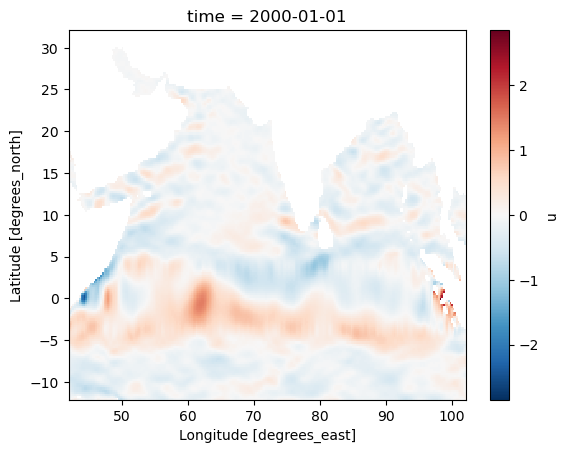

In [20]:
sla.u.isel(time=0).plot.imshow()

In [23]:
# export 
sla.to_netcdf('shared/data/finalized/currents.nc')